## GB2 대로 전처리 해보기
- EDA: [Extensive EDA and Modeling XGB Hyperopt](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)
- modeling: [IEEE - GB-2 (make Amount useful again)](https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again)
- feature engineering 중점 사항: 이걸 하나씩 바꿔 가면서 정확도 해보기!! submission 파일 따로 저장하고 **커밋시 메시지에 해당 내용 꼭 쓰기**
    - null 데이터는 일단 그대로 두기
    - P_emaildomain: boolean으로. mail.com or not
    - R_emaildomain: boolean으로? apple.com or not
    > 원래 이메일을 bool로 바꿔 보기!! 파싱하지 말고.
    - id_23: ip_proxy or not? ip_proxy는 사기치려고 들어오는 사람들.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, warnings, random, datetime
print(os.listdir("../input"))

import lightgbm as lgb

from tqdm import tqdm

import math
warnings.filterwarnings('ignore')

#standard plotly imports
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

#import cufflinks
import plotly.figure_factory as ff

#using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)

#preprocessing, modeling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

['df_id.pkl', 'df_pca.pkl', 'df_test.pkl', 'df_train.pkl', 'df_trans.pkl', 'sample_submission.csv', 'test.pkl', 'test_0823.pkl', 'test_identity.csv', 'test_transaction.csv', 'train_0823.pkl', 'train_identity.csv', 'train_transaction.csv']


In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [3]:
df_train_init = pd.read_pickle("../input/df_train.pkl")
base_columns = list(df_train_init)
base_columns.append('P_emaildomain_bool')
base_columns.append('R_emaildomain_bool')

In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
# PCA 안하고, 메일 처리 안한 거로 읽기(mail.com 살리기 위해)
df_train = pd.read_pickle("../input/df_train.pkl")
df_test = pd.read_pickle("../input/df_test.pkl")
#must be 645.97
print("{:1.2f} Mb".format(df_train.memory_usage().sum() / 1024**2))
#must be 561.50
print("{:1.2f} Mb".format(df_test.memory_usage().sum() / 1024**2)) 

645.97 Mb
561.50 Mb


In [6]:
total = len(df_train)
total_amt = df_train['TransactionAmt'].sum()
TARGET = 'isFraud'

def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

In [7]:
df_train['P_emaildomain'].unique().shape

(60,)

In [ ]:
# 추가적인 전처리. mail.com 살리고 시각화 해보기(ploting_cnt_amt)
# df_train.P_emaildomain.fillna("NoInf", inplace=True)
# df_test.R_emaildomain.fillna("NoInf", inplace=True)

# dict에서 mail.com 만 제거
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    # bin -> emails dict에 따라 매핑(수정)
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    # suffix -> 도메인 중 맨 마지막(. 뒤에) 부분
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    # suffix 확인 -> us_email 값에 해당 안하면 그대로. 해당하면 'us'로
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [8]:
# 우선 이렇게 바꿔보고 binary 처리 해보기
df_train.loc[df_train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'
df_test.loc[df_test['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df_train.loc[df_train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_test.loc[df_test['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'

df_train.loc[df_train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_test.loc[df_test['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'

df_train.loc[df_train.P_emaildomain.isin(df_train.P_emaildomain\
                                         .value_counts()[df_test.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_test.loc[df_test.P_emaildomain.isin(df_test.P_emaildomain\
                                         .value_counts()[df_test.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"

#df_train.P_emaildomain.fillna("NoInf", inplace=True)

isFraud  P_emaildomain    NoFraud      Fraud   count       perc
12            mail.com  81.037567  18.962433     559   0.094659
1            Microsoft  94.670209   5.329791   59477  10.071629
0               Google  95.650445   4.349555  228851  38.752836
11          icloud.com  96.856550   3.143450    6267   1.061232
9          comcast.net  96.881339   3.118661    7888   1.335727
8          charter.net  96.936275   3.063725     816   0.138179
7        bellsouth.net  97.223677   2.776323    1909   0.323263


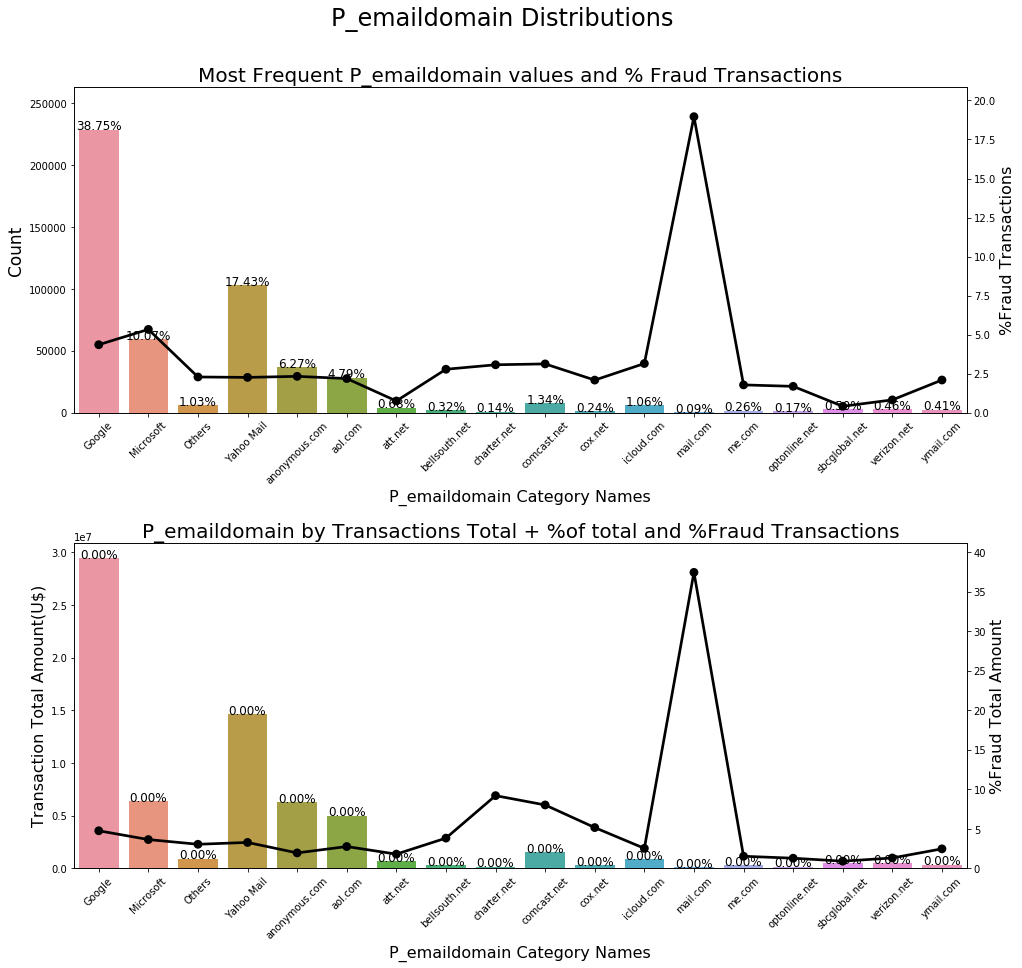

In [11]:
# reshape위해 float16 -> float64로 형식 변경.
# 모델링 할 때 다시 바꾸기!!
df_train['TransactionAmt'] = df_train['TransactionAmt'].astype('float64')

# Fraud % 높은 이메일 도메인 보기
# count까지 고려해야 하나? 상당히 비율은 작음.
tmp = pd.crosstab(df_train['P_emaildomain'], df_train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp['count'] = df_train['P_emaildomain'].value_counts()[tmp['P_emaildomain']].values
tmp['perc'] = df_train['P_emaildomain'].value_counts()[tmp['P_emaildomain']].values / total * 100
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))

#df_train['P_emaildomain'] = (df_train['P_emaildomain'] == 'mail.com')
ploting_cnt_amt(df_train, 'P_emaildomain')

In [9]:
df_train['P_emaildomain_bool'] = (df_train['P_emaildomain'] == 'mail.com').apply(
lambda x:1 if x else 0)
df_test['P_emaildomain_bool'] = (df_test['P_emaildomain'] == 'mail.com').apply(
lambda x:1 if x else 0)
df_train['P_emaildomain_bool'].value_counts()

0    589981
1       559
Name: P_emaildomain_bool, dtype: int64

In [10]:
df_train.loc[df_train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'
df_test.loc[df_test['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_train.loc[df_train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_test.loc[df_test['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'

df_train.loc[df_train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_test.loc[df_test['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'

df_train.loc[df_train.R_emaildomain.isin(df_train.R_emaildomain\
                                         .value_counts()[df_test.R_emaildomain.value_counts() <= 500 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_test.loc[df_test.R_emaildomain.isin(df_test.R_emaildomain\
                                         .value_counts()[df_test.R_emaildomain.value_counts() <= 500 ]\
                                         .index), 'R_emaildomain'] = "Others"

#df_train.R_emaildomain.fillna("NoInf", inplace=True)

isFraud  R_emaildomain    NoFraud      Fraud  count
7           icloud.com  87.124464  12.875536   1398
0               Google  88.101394  11.898606  57242
1            Microsoft  91.923581   8.076419  33604
3           Yahoo Mail  95.376525   4.623475  13691
2               Others  96.402677   3.597323   3586
5              aol.com  96.514456   3.485544   3701
4        anonymous.com  97.087048   2.912952  20529


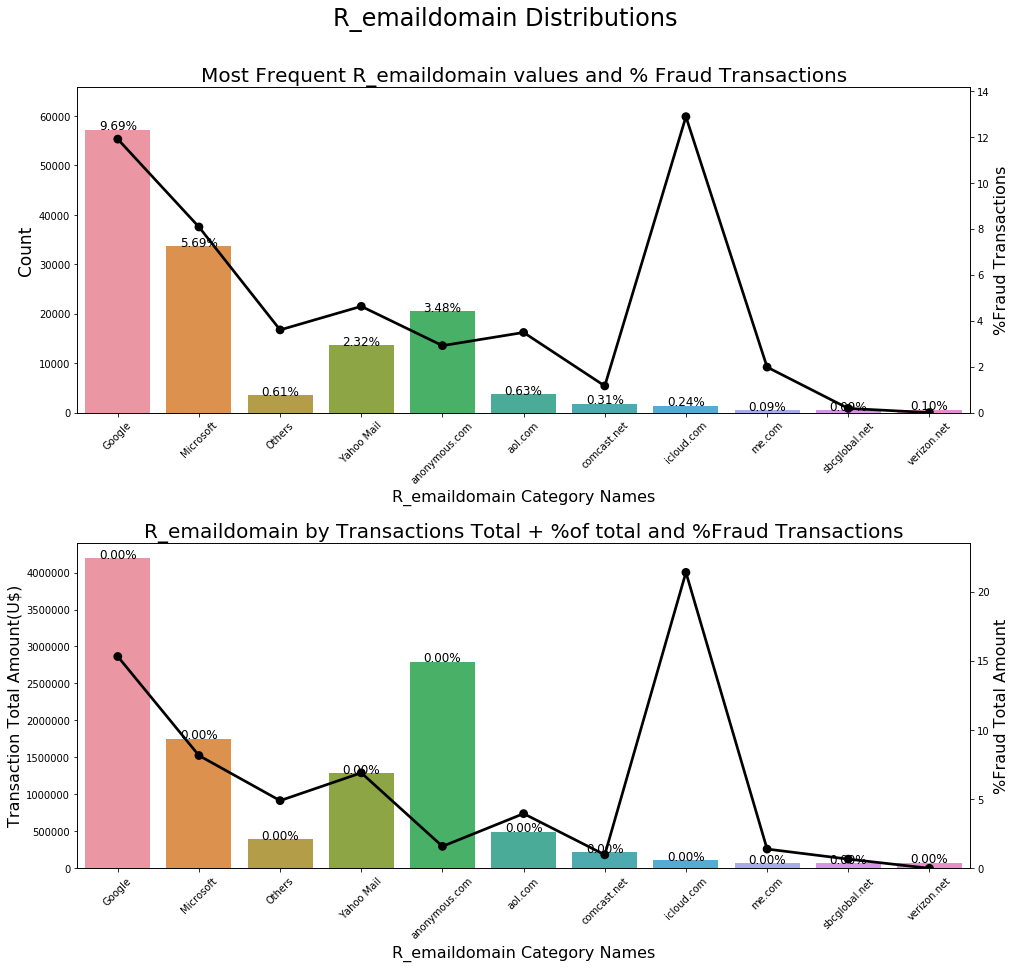

In [25]:
# R_emaildomain은 애매함. 일단 놔두기?
# 근데 이거로 봤을때 Fraud%가 높은 것들이 있음. 이걸로 binary를 판단하기?
tmp = pd.crosstab(df_train['R_emaildomain'], df_train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp['count'] = df_train['R_emaildomain'].value_counts()[tmp['R_emaildomain']].values
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))
# df_train['R_emaildomain'] = ((df_train['R_emaildomain'] == 'icloud.com') |
#                             (df_train['R_emaildomain'] == 'icloud.com'))
ploting_cnt_amt(df_train, 'R_emaildomain')

In [11]:
df_train['R_emaildomain_bool'] = (df_train['R_emaildomain'] == 'icloud.com').apply(
lambda x:1 if x else 0)
df_test['R_emaildomain_bool'] = (df_test['R_emaildomain'] == 'icloud.com').apply(
lambda x:1 if x else 0)
df_train['R_emaildomain_bool'].value_counts()

0    589142
1      1398
Name: R_emaildomain_bool, dtype: int64

In [73]:
np.where(df_train['D9'].isna(), 0, 1)

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
for df in [df_train, df_test]:
    df['DT'] = df['TransactionDT'].apply(
        lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column: null이면 0, 아니면 1
    df['D9'] = np.where(df['D9'].isna(), 0, 1)

In [13]:
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([df_train[[col]], df_test[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)
    
    # df_train 값이 df_test 에도 있으면 그대로, 없으면 nan으로
    df_train[col] = np.where(df_train[col].isin(df_test[col]), 
                             df_train[col], np.nan)
    # 반대로 df_test 값이 df_train에도 있으면 그대로, 없으면 nan
    df_test[col]  = np.where(df_test[col].isin(df_train[col]), 
                             df_test[col], np.nan)

    df_train[col] = np.where(df_train[col].isin(valid_card), 
                             df_train[col], np.nan)
    df_test[col]  = np.where(df_test[col].isin(valid_card), 
                             df_test[col], np.nan)

In [14]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

# raw data는 T/F -> null 여부를 0(null), 1(null 아님)로 매핑
for col in i_cols:
    df_train[col] = np.where(df_train[col].isna(), 0, 1)
    df_test[col] = np.where(df_test[col].isna(), 0, 1)

for df in [df_train, df_test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [15]:
for col in ['ProductCD', 'M4']:
    temp_dict = df_train.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
        columns = {'mean': col + '_target_mean'}
    )
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()
    print(temp_dict)
    
    # ProductCD별, M4별 mean 칼럼을 추가
    df_train[col + '_target_mean'] = df_train[col].map(temp_dict)
    df_test[col + '_target_mean'] = df_test[col].map(temp_dict)

{'C': 0.11687269224594637, 'H': 0.04766230620155039, 'R': 0.03782593702750736, 'S': 0.058995528035775714, 'W': 0.020399390451929858}
{'M0': 0.03664876148774217, 'M1': 0.02705107333510014, 'M2': 0.11373924663826944}


Text(0, 0.5, 'Probability')

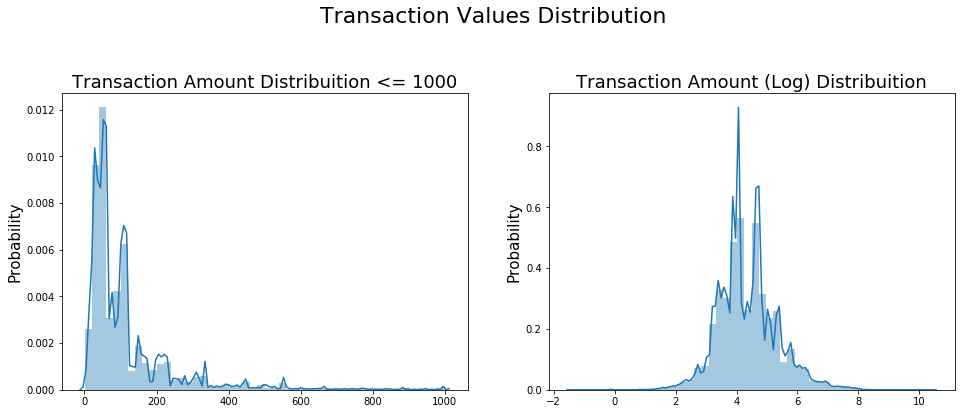

In [31]:
# TransactionAmt 아직 로그 처리 안된 것 확인
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_train[df_train['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_train['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

In [16]:
df_train['uid'] = df_train['card1'].astype(str)+'_'+df_train['card2'].astype(str)
df_test['uid'] = df_test['card1'].astype(str)+'_'+df_test['card2'].astype(str)

df_train['uid2'] = df_train['uid'].astype(str)+'_'+df_train['card3'].astype(str)+'_'+df_train['card5'].astype(str)
df_test['uid2'] = df_test['uid'].astype(str)+'_'+df_test['card3'].astype(str)+'_'+df_test['card5'].astype(str)

df_train['uid3'] = df_train['uid2'].astype(str)+'_'+df_train['addr1'].astype(str)+'_'+df_train['addr2'].astype(str)
df_test['uid3'] = df_test['uid2'].astype(str)+'_'+df_test['addr1'].astype(str)+'_'+df_test['addr2'].astype(str)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
df_train['TransactionAmt_check'] = np.where(df_train['TransactionAmt'].isin(df_test['TransactionAmt']), 1, 0)
df_test['TransactionAmt_check']  = np.where(df_test['TransactionAmt'].isin(df_train['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([df_train[[col, 'TransactionAmt']], df_test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        df_train[new_col_name] = df_train[col].map(temp_df)
        df_test[new_col_name]  = df_test[col].map(temp_df)
           
# Small "hack" to transform distribution 
# (doesn't affect auc much, but I like it more)
# please see how distribution transformation can boost your score 
# (not our case but related)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
# 계산 오류 방지를 위해 x+1에 로그 취하는 함수 -> log1p
df_train['TransactionAmt'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log1p(df_test['TransactionAmt'])

In [17]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [df_train, df_test]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

In [18]:
########################### Device info
for df in [df_train, df_test]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [19]:
########################### Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([
        df_train[[col]], 
        df_test[[col]]
    ])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    df_train[col+'_fq_enc'] = df_train[col].map(fq_encode)
    df_test[col+'_fq_enc']  = df_test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([df_train[[col]], df_test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    df_train[col+'_total'] = df_train[col].map(fq_encode)
    df_test[col+'_total']  = df_test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([df_train[[col,period]], df_test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        df_train[new_column] = (df_train[col].astype(str) + '_' + df_train[period].astype(str)).map(fq_encode)
        df_test[new_column]  = (df_test[col].astype(str) + '_' + df_test[period].astype(str)).map(fq_encode)
        
        df_train[new_column] /= df_train[period+'_total']
        df_test[new_column]  /= df_test[period+'_total']

In [20]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(df_train):
    if df_train[col].dtype=='O':
        print(col)
        df_train[col] = df_train[col].fillna('unseen_before_label')
        df_test[col]  = df_test[col].fillna('unseen_before_label')
        
        df_train[col] = df_train[col].astype(str)
        df_test[col] = df_test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(df_train[col])+list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col]  = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')
        
# 커널 결과와 다른데, 칼럼들에 처리 해준건지??

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M4
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
uid
uid2
uid3
P_emaildomain_prefix
R_emaildomain_prefix
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device


In [21]:
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(df_train)).difference(base_columns+rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(df_test[i], df_train[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# We will reset this list for now (use local test drop),
# Good droping will be in other kernels
# with better checking
features_discard = [] 

# Final features list
features_columns = [col for col in list(df_train) if col not in rm_cols + features_discard]

['C12_fq_enc', 'D4_fq_enc', 'D5_fq_enc', 'D3_fq_enc', 'M_sum', 'id_31_device', 'uid_DT_D', 'D6_fq_enc', 'D7_fq_enc']


In [22]:
len(features_columns) # 503

503

## Modeling

In [23]:
def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df

In [24]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                }

In [25]:
sample_submission = pd.read_csv("../input/sample_submission.csv",
                               index_col = 'TransactionID')

df_test = df_test.merge(sample_submission, how='left', left_index=True,
                         right_index=True, on='TransactionID')

In [26]:
df_train['P_emaildomain_bool'] = df_train['P_emaildomain_bool'].astype(np.int8)
df_train['R_emaildomain_bool'] = df_train['R_emaildomain_bool'].astype(np.int8)
df_test['P_emaildomain_bool'] = df_test['P_emaildomain_bool'].astype(np.int8)
df_test['R_emaildomain_bool'] = df_test['R_emaildomain_bool'].astype(np.int8)

In [27]:
if LOCAL_TEST:
    lgb_params['learning_rate'] = 0.01
    lgb_params['n_estimators'] = 20000
    lgb_params['early_stopping_rounds'] = 100
    test_predictions = make_predictions(df_train, df_test, features_columns, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
else:
    lgb_params['learning_rate'] = 0.005
    lgb_params['n_estimators'] = 1800
    lgb_params['early_stopping_rounds'] = 100    
    test_predictions = make_predictions(df_train, df_test, features_columns, TARGET, lgb_params, NFOLDS=5)

Fold: 0
472432 118108
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.936253	valid_1's auc: 0.92281
[400]	training's auc: 0.961436	valid_1's auc: 0.940439
[600]	training's auc: 0.978194	valid_1's auc: 0.951284
[800]	training's auc: 0.987055	valid_1's auc: 0.957242
[1000]	training's auc: 0.991823	valid_1's auc: 0.961028
[1200]	training's auc: 0.994542	valid_1's auc: 0.963572
[1400]	training's auc: 0.996244	valid_1's auc: 0.965309
[1600]	training's auc: 0.997306	valid_1's auc: 0.966568
[1800]	training's auc: 0.998074	valid_1's auc: 0.967601
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 0.998074	valid_1's auc: 0.967601
Fold: 1
472432 118108
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.936525	valid_1's auc: 0.92021
[400]	training's auc: 0.962081	valid_1's auc: 0.938897
[600]	training's auc: 0.977825	valid_1's auc: 0.950127
[800]	training's auc: 0.987041	valid_1's auc: 0.957086
[1000]	t

In [28]:
if not LOCAL_TEST:
    test_predictions['isFraud'] = test_predictions['prediction']
    test_predictions[['TransactionID','isFraud']].to_csv('gb2_submission.csv', index=False)